In [1]:
import os
import sys
import logging
FORMAT = "%(filename)s:%(lineno)d %(funcName)s %(levelname)s %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

import re
import imp
import itertools
import random
import numpy as np
from numpy import array
import pandas as pd
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns


# do this before we have a chance to import openbabel!
import rdkit, rdkit.Chem.rdDistGeom, rdkit.DistanceGeometry

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import rdBase

import py3Dmol

from rmgpy.molecule import Molecule
from rmgpy.species import Species
from rmgpy.reaction import Reaction


from multi_molecule import *
from multi_reaction import *

from ase.calculators.morse import * #chosing this calculator for now because it's fast
from ase.calculators.dftb import *
from ase.calculators.lj import *
from ase.calculators.emt import *

from ga import *
from simple_es import *

from copy import deepcopy

thermo.py:760 loadLibraries INFO Loading thermodynamics library from CBS_QB3_1dHR.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:760 loadLibraries INFO Loading thermodynamics library from KlippensteinH2O2.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:760 loadLibraries INFO Loading thermodynamics library from primaryThermoLibrary.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:760 loadLibraries INFO Loading thermodynamics library from thermo_DFT_CCSDTF12_BAC.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:774 loadGroups INFO Loading thermodynamics group database from /Users/nathan/Code/RMG-database/input/thermo/groups...
transport.py:294 loadGroups INFO Loading transport group database from /Users/nathan/Code/RMG-database/input/transport/groups...
database.py:165 loadFamilies INFO Loading the user-specified kinetics families from /Users/nathan/Code/RMG-database/input/kinetics/famil

# The ultimate goal of this notebook is to implement the ES-CMA method. The method boils down to the following equation 

## $ x_i \sim m_k + \sigma_k \cdot \mathcal{N}(0,\,C_k)$  

### We'll be going through this equation step by step and applying it to conformer analysis

In [49]:
mol = Multi_Molecule("COCCC")
mol.ase_molecule.set_calculator(EMT())
mol.view_mol()

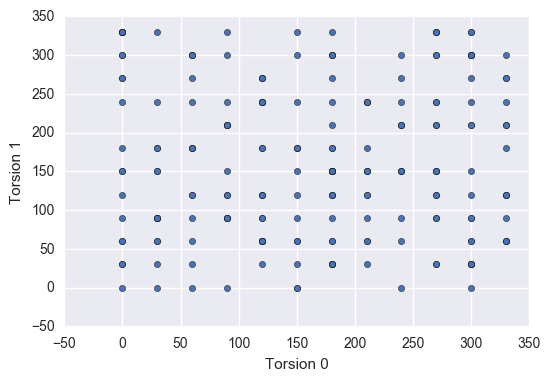

In [50]:
population = create_initial_population(mol, population_size=200)
population.plot(kind="scatter", x="Torsion 0", y="Torsion 1")

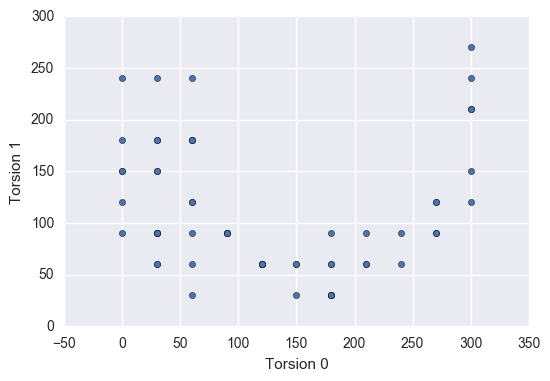

In [51]:
top_percent = 0.3
population_size = population.shape[0]
top_population = population_size * top_percent

top = population.iloc[:int(top_population), :]

top.plot(kind="scatter", x="Torsion 0", y="Torsion 1")

In [54]:
shape_0 = top.shape[0]
shape_1 = top.shape[1] -1
print top.shape
weighted_average = np.zeros((shape_1, 1))
for i, value in enumerate(reversed((top.values))):
    
    weighted_average = weighted_average + ((float(i+1) * value[1:] / shape_0**2).reshape(shape_1, 1))
    
weighted_average

(60, 3)


array([[ 53.10833333],
       [ 52.40833333]])

In [55]:
C = np.zeros(shape_1)

for value in (top.values):
    C = C + (value[1:].reshape((shape_1, 1)) - weighted_average).dot((value[1:].reshape((shape_1, 1)) - weighted_average).T)
    
C

array([[ 889518.20416667,  237456.15416667],
       [ 237456.15416667,  435563.50416667]])

In [71]:
results = []
for i in range(population_size):
    x_i = np.random.multivariate_normal(weighted_average.reshape(2,), C)
    
    for index, value in enumerate(x_i):
        x_i[index] = value % 360
        
    dihedrals= []
    for t, torsion in enumerate(mol.torsions):
        i, j, k, l = torsion.indices
        RHS = torsion.RHS
        dihedral = x_i[t]

        dihedrals.append(dihedral)
        mol.ase_molecule.set_dihedral(a1=i,
                                      a2=j,
                                      a3=k,
                                      a4=l,
                                      angle=float(dihedral),
                                      indices=RHS)
        e = mol.ase_molecule.get_potential_energy()
        
    results.append([e] + dihedrals)

dff = pd.DataFrame(results)

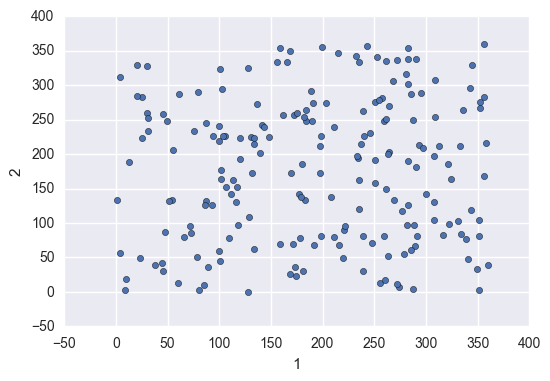

In [72]:
dff.plot(kind="scatter", x=1, y=2)

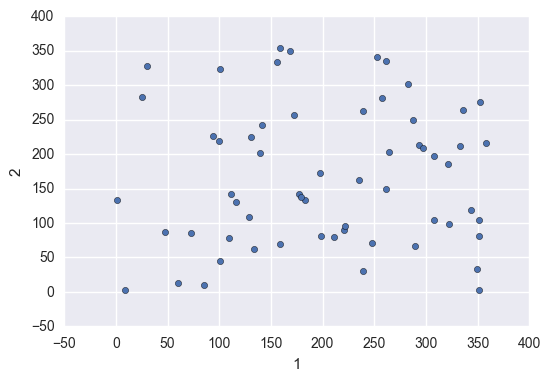

In [73]:
top_percent = 0.3
population_size = dff.shape[0]
top_population = population_size * top_percent

top = dff.iloc[:int(top_population), :]

top.plot(kind="scatter", x=1, y=2)

(60, 3)


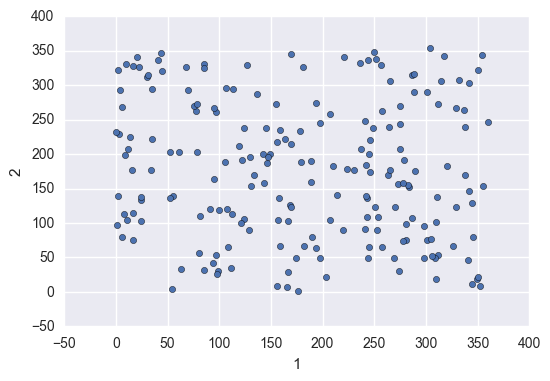

In [74]:
shape_0 = top.shape[0]
shape_1 = top.shape[1] -1
print top.shape
weighted_average = np.zeros((shape_1, 1))
for i, value in enumerate(reversed((top.values))):
    
    weighted_average = weighted_average + ((float(i+1) * value[1:] / shape_0**2).reshape(shape_1, 1))

C = np.zeros(shape_1)

for value in (top.values):
    C = C + (value[1:].reshape((shape_1, 1)) - weighted_average).dot((value[1:].reshape((shape_1, 1)) - weighted_average).T)
    
results = []
for i in range(population_size):
    x_i = np.random.multivariate_normal(weighted_average.reshape(2,), C)
    for index, value in enumerate(x_i):
        x_i[index] = value % 360
    dihedrals= []
    for t, torsion in enumerate(mol.torsions):
        i, j, k, l = torsion.indices
        RHS = torsion.RHS
        dihedral = x_i[t]

        dihedrals.append(dihedral)
        mol.ase_molecule.set_dihedral(a1=i,
                                      a2=j,
                                      a3=k,
                                      a4=l,
                                      angle=float(dihedral),
                                      indices=RHS)
        e = mol.ase_molecule.get_potential_energy()
        
    results.append([e] + dihedrals)

dff = pd.DataFrame(results)
dff.plot(kind="scatter", x=1, y=2)

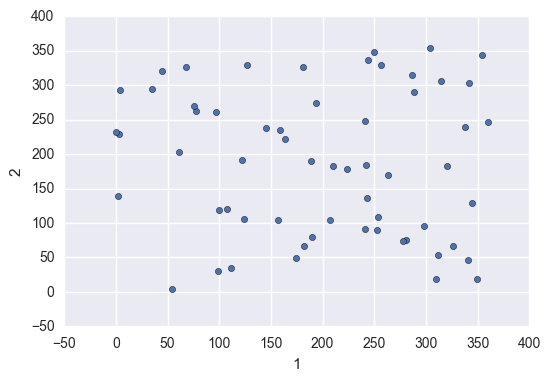

In [75]:
top_percent = 0.3
population_size = dff.shape[0]
top_population = population_size * top_percent

top = dff.iloc[:int(top_population), :]

top.plot(kind="scatter", x=1, y=2)

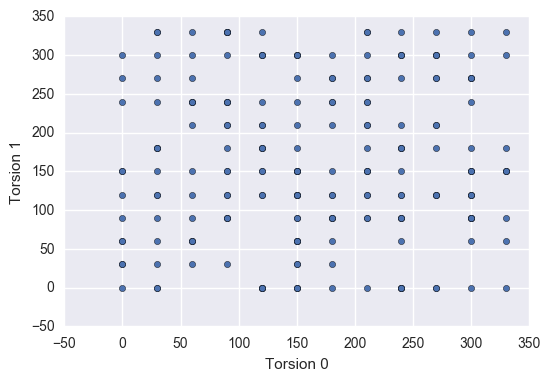

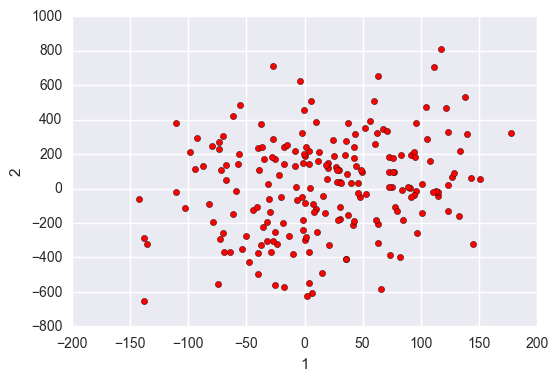

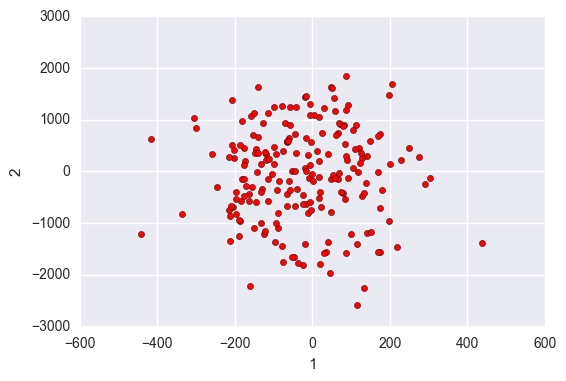

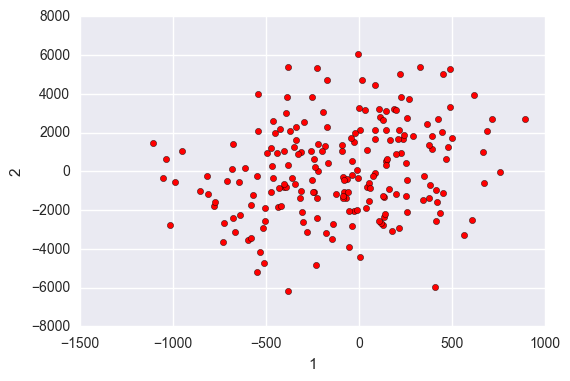

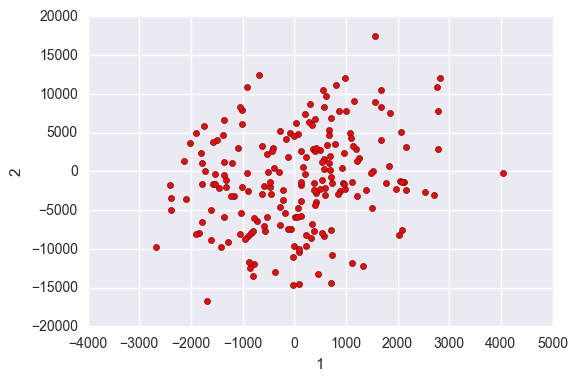

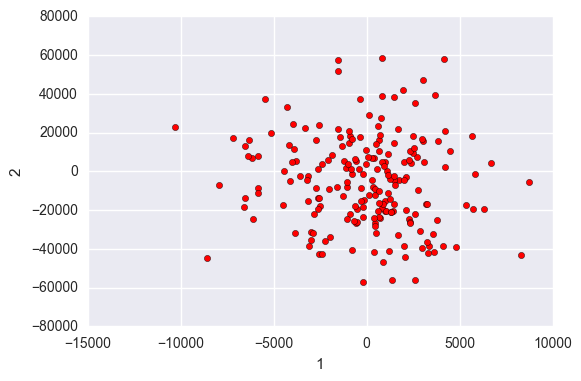

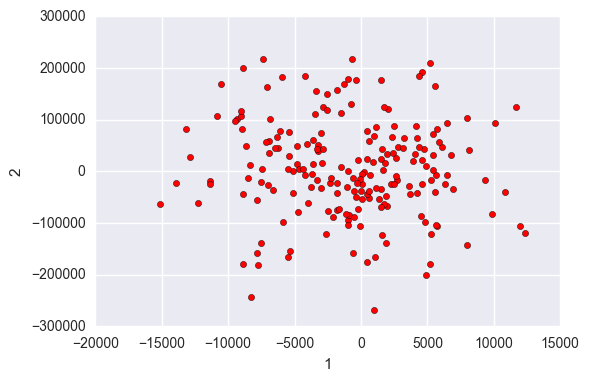

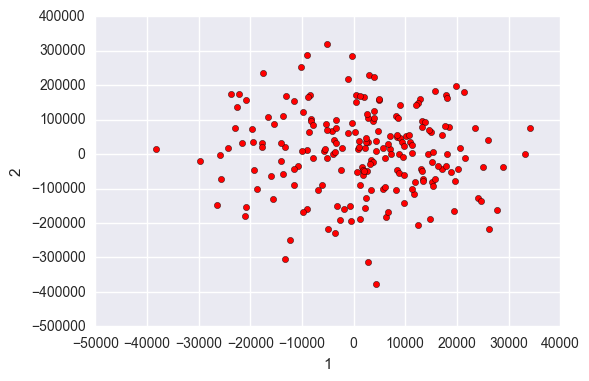

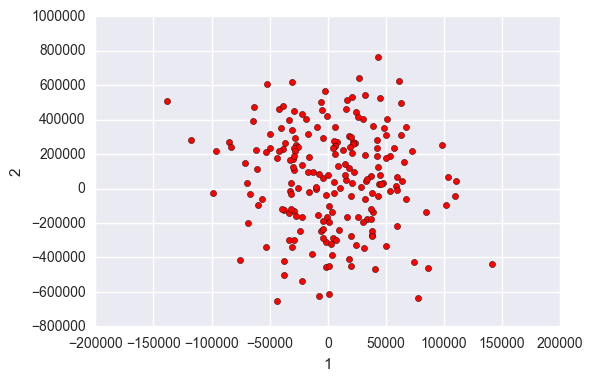

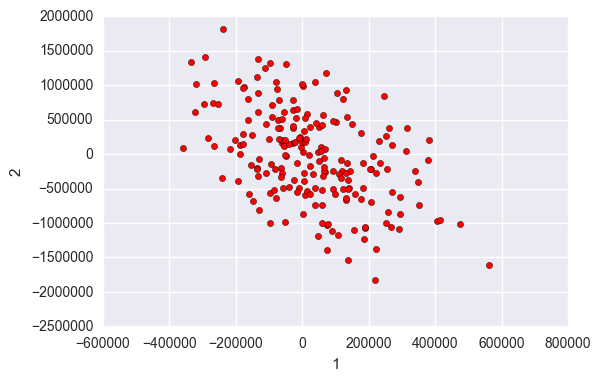

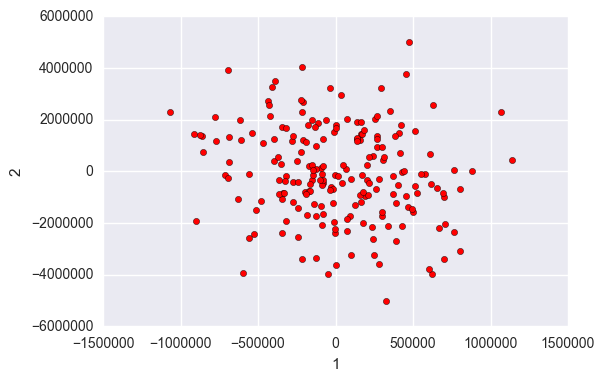

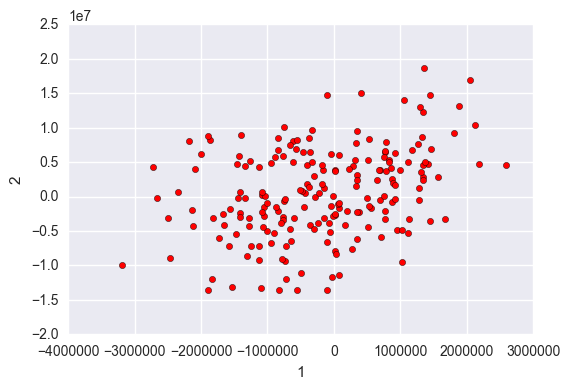

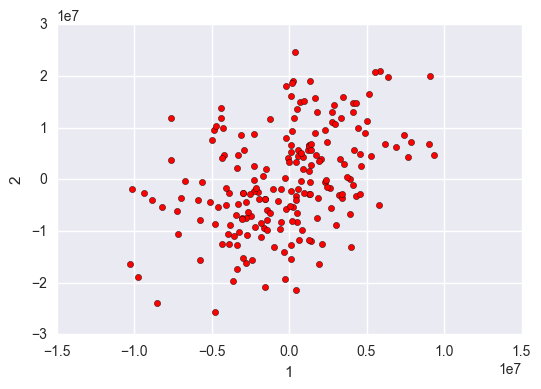

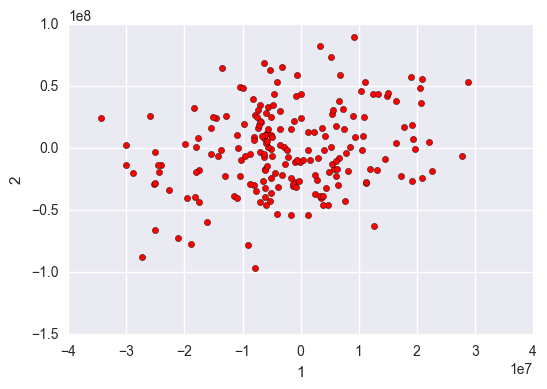

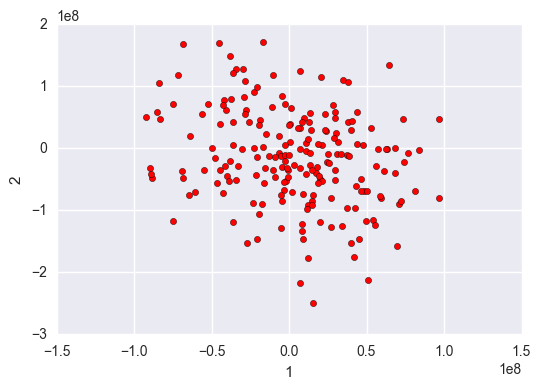

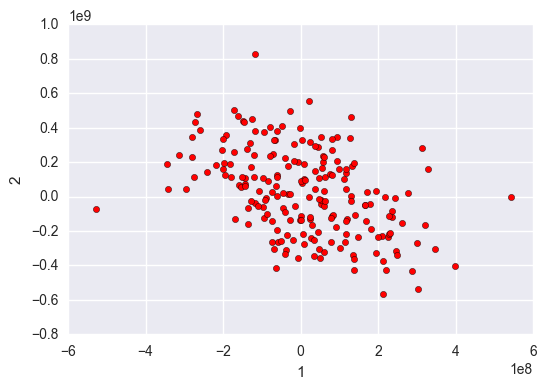

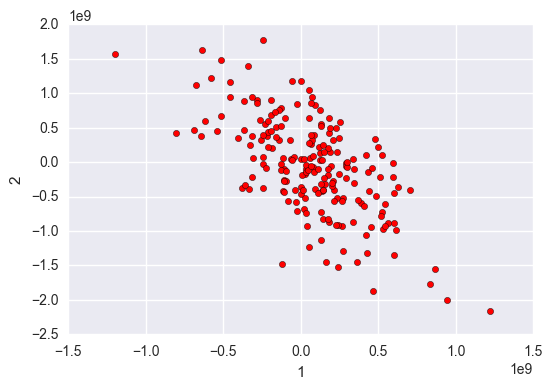

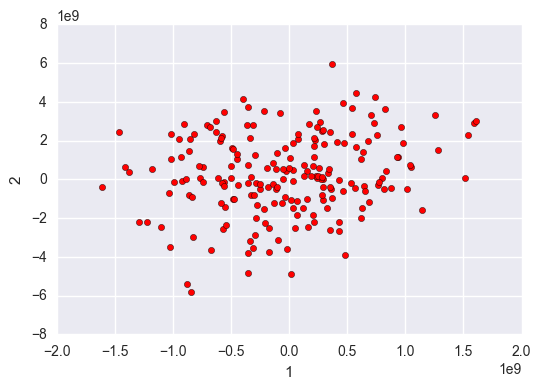

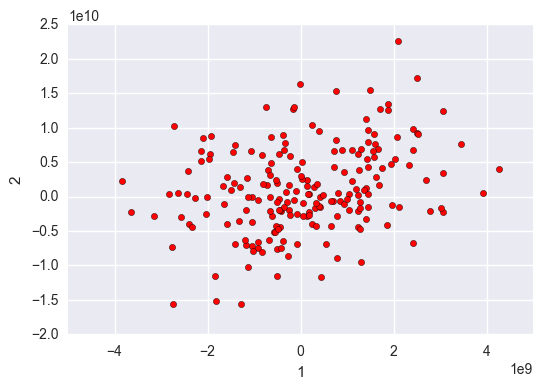

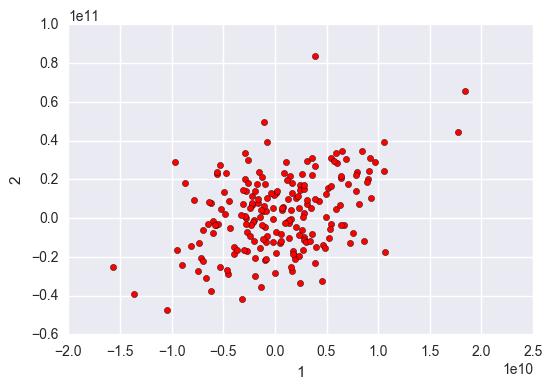

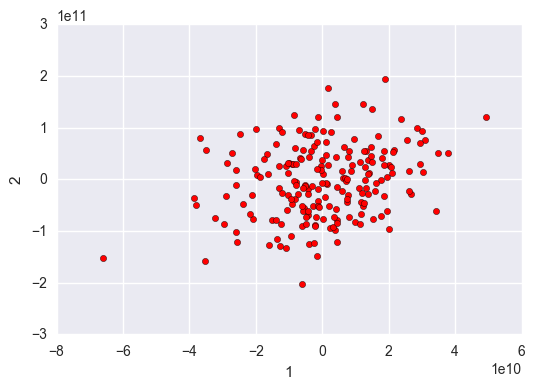

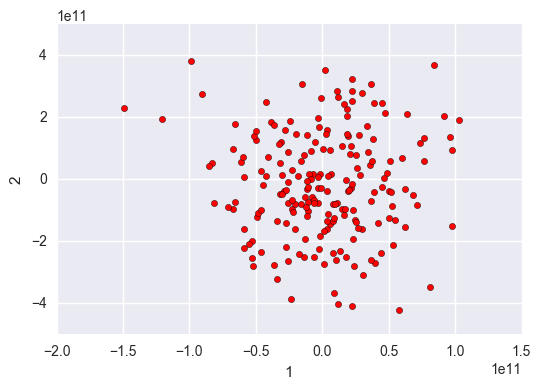

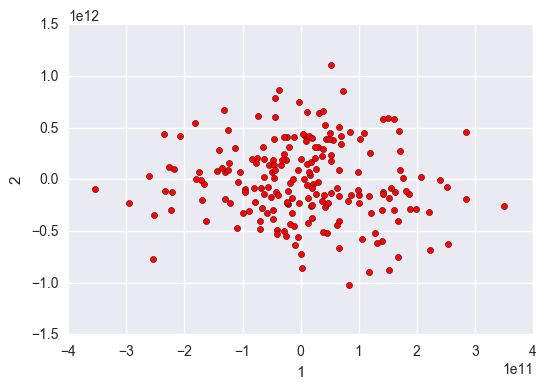

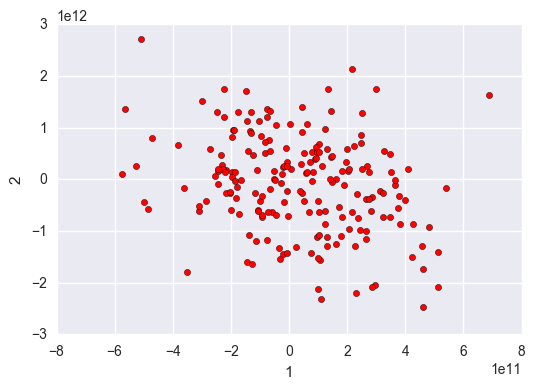

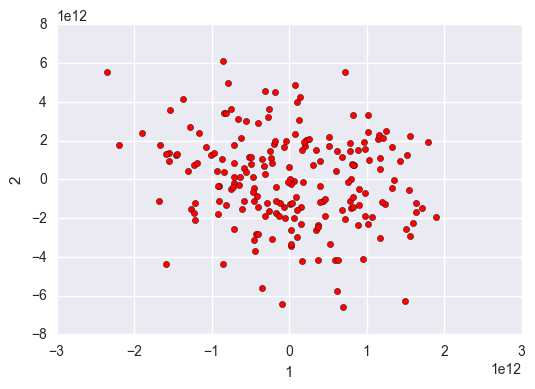

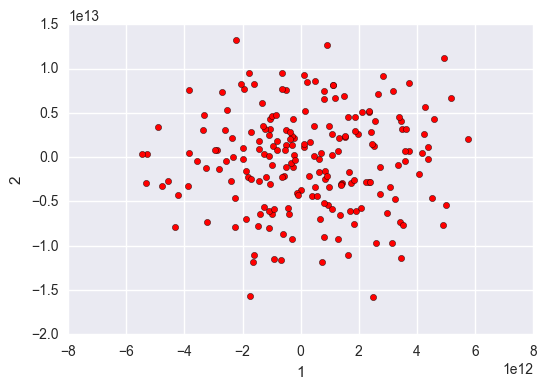

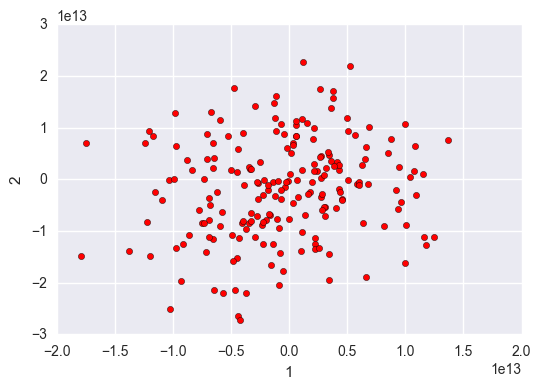

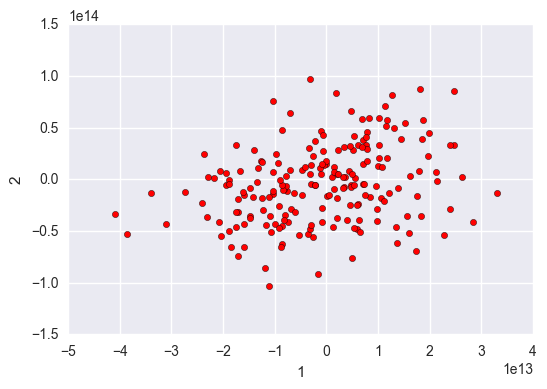

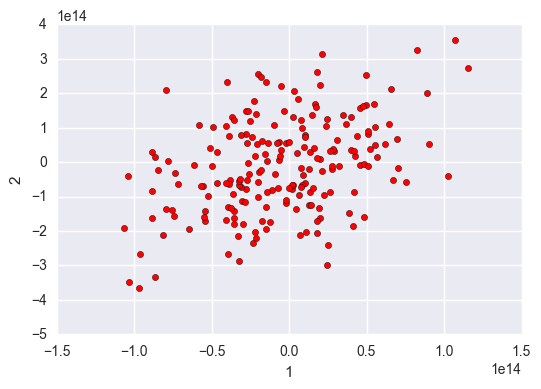

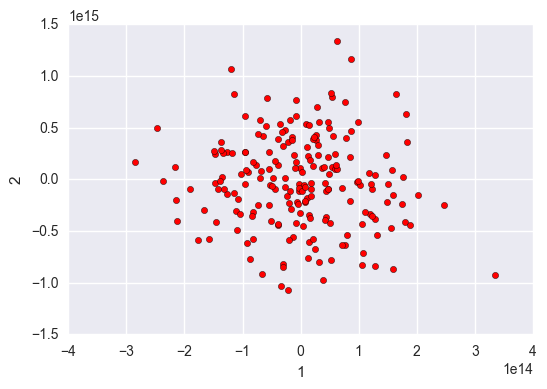

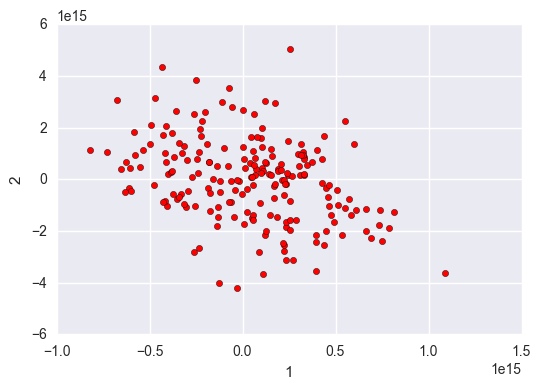

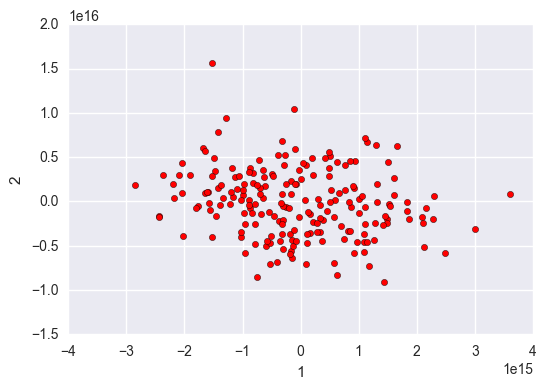

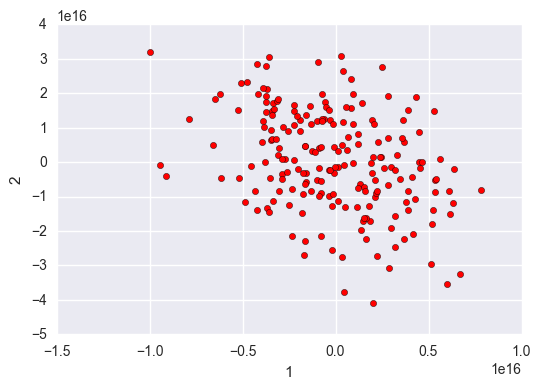

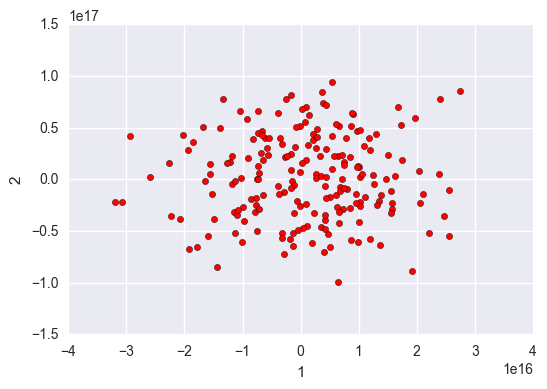

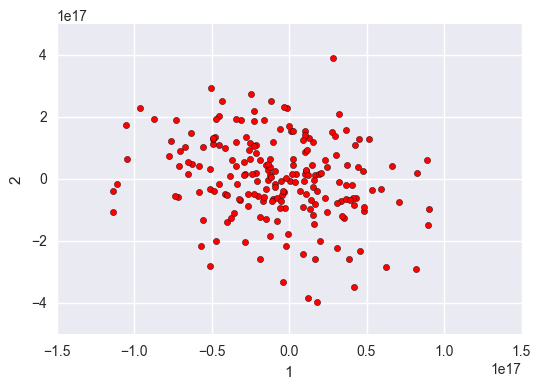

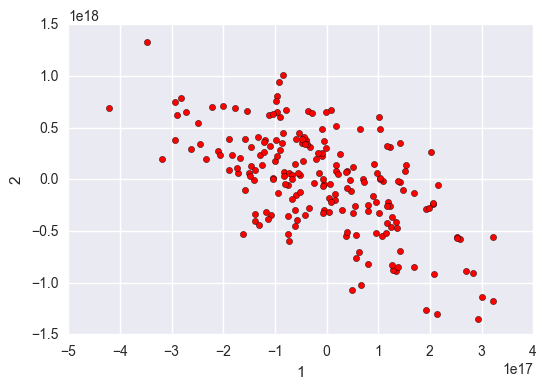

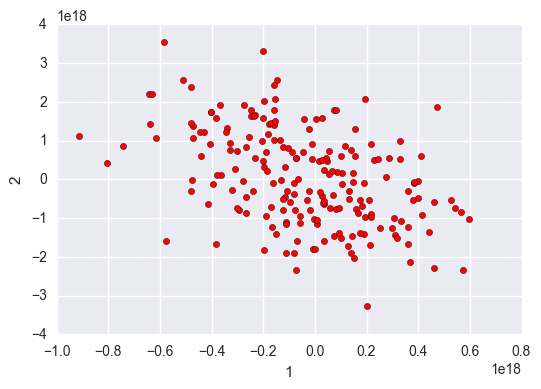

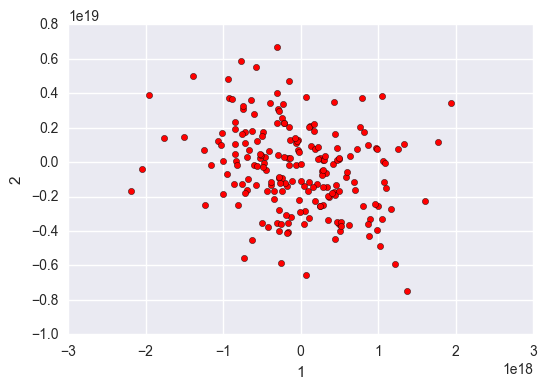

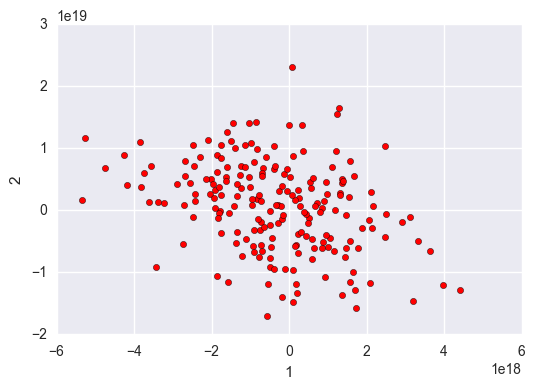

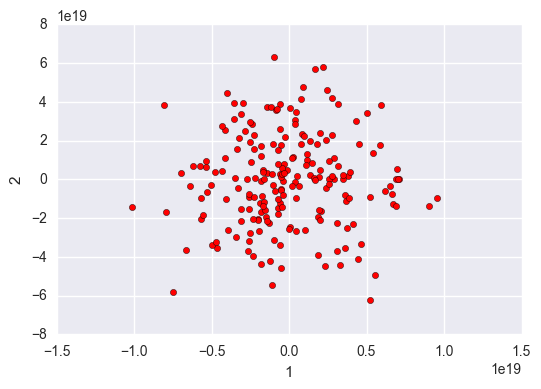

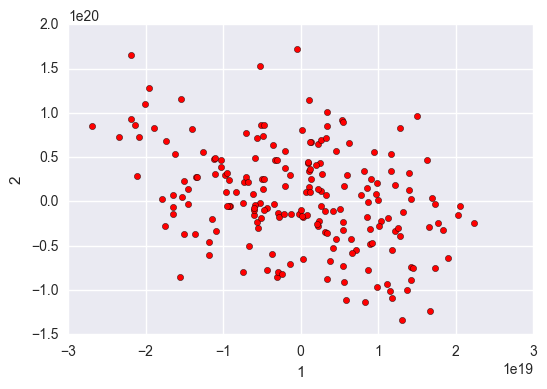

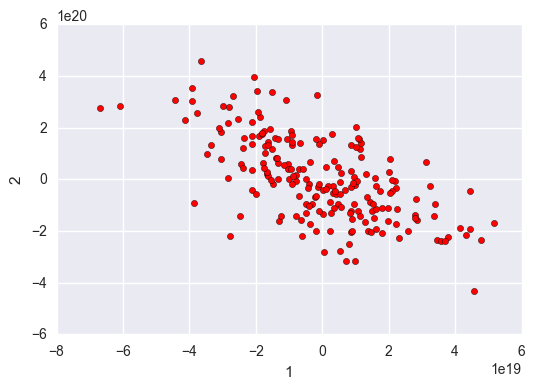

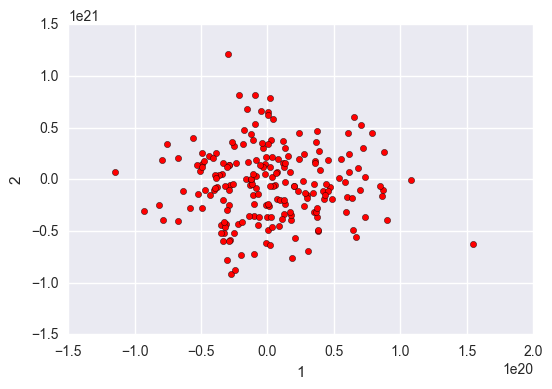

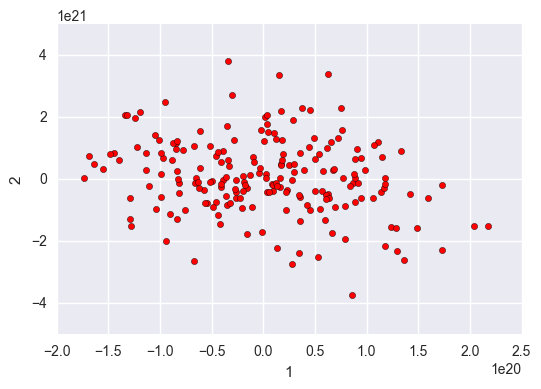

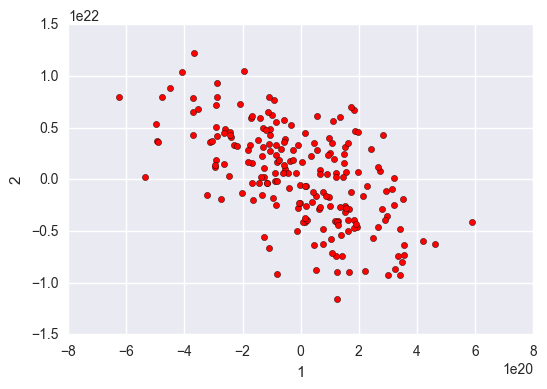

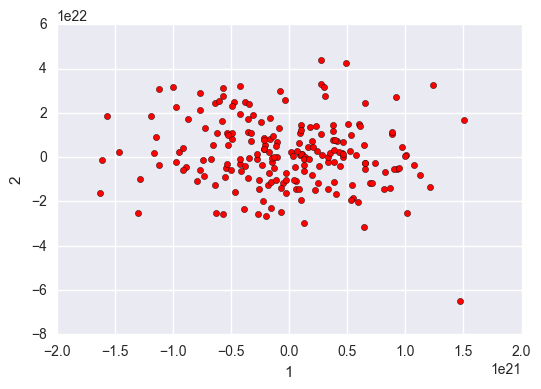

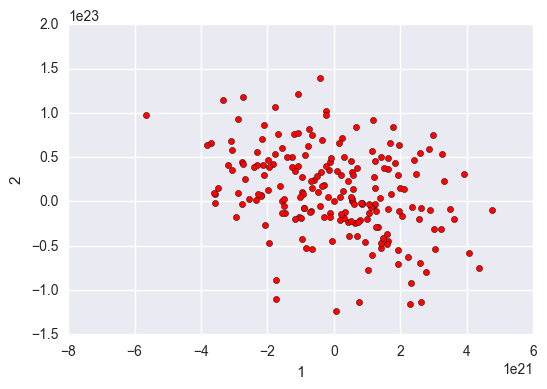

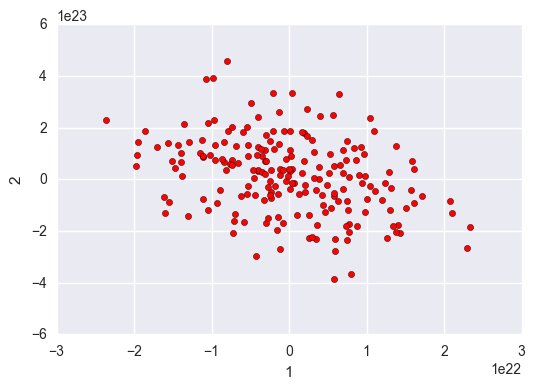

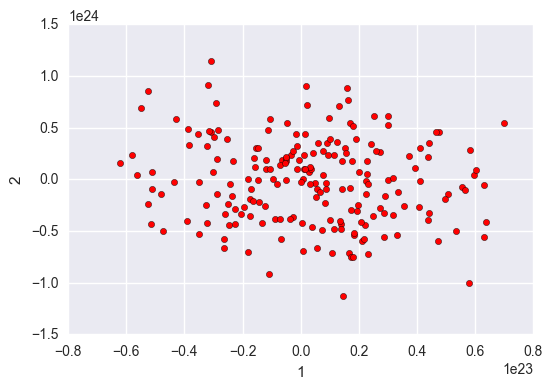

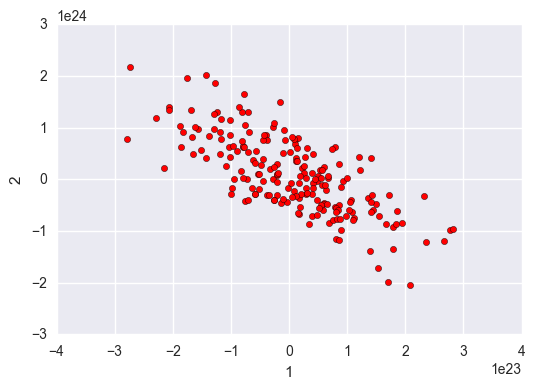

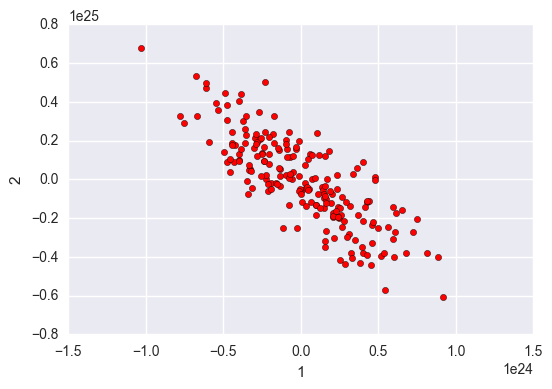

In [96]:
population = create_initial_population(mol, population_size=200)
pltt = population.plot(kind="scatter", x="Torsion 0", y="Torsion 1")
fig = pltt.get_figure()
fig.show()

generations = 50
top_percent = 0.05
population_size = population.shape[0]
top_population = population_size * top_percent

for generation in range(generations):
    

    top = population.iloc[:int(top_population), :]

    #top.plot(kind="scatter", x=1, y=2).get_figure()
    
    
    shape_0 = top.shape[0]
    shape_1 = top.shape[1] -1
    weighted_average = np.zeros((shape_1, 1))
    
    for i, value in enumerate(reversed((top.values))):

        weighted_average = weighted_average + ((float(i+1) * value[1:] / shape_0**2).reshape(shape_1, 1))
        
    C = np.zeros(shape_1)

    for value in (top.values):
        C = C + (value[1:].reshape((shape_1, 1)) - weighted_average).dot((value[1:].reshape((shape_1, 1)) - weighted_average).T)

    results = []
    for i in range(population_size):
        x_i = np.random.multivariate_normal(weighted_average.reshape(2,), C)
        """for index, value in enumerate(x_i):
            x_i[index] = value % 360"""
        dihedrals= []
        for t, torsion in enumerate(mol.torsions):
            i, j, k, l = torsion.indices
            RHS = torsion.RHS
            dihedral = x_i[t]

            dihedrals.append(dihedral)
            mol.ase_molecule.set_dihedral(a1=i,
                                          a2=j,
                                          a3=k,
                                          a4=l,
                                          angle=float(dihedral),
                                          indices=RHS)
            e = mol.ase_molecule.get_potential_energy()

        results.append([e] + dihedrals)

    population = pd.DataFrame(results)
    population.plot(kind="scatter", x=1, y=2, c="r")
        
    
    
    
    

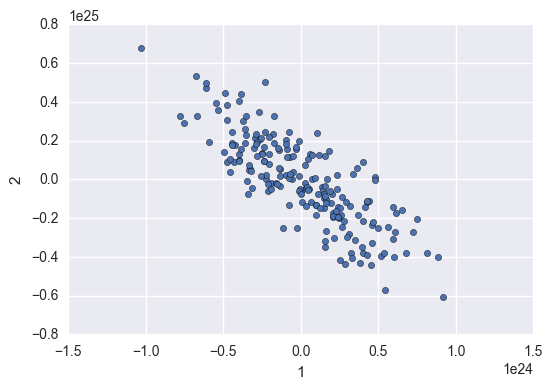

In [102]:
population.plot(kind="scatter", x=1, y=2) #logy=True, logx=True)

## Getting the weighted average of the top values

The equation for the weighted average is as follows:

### $m_{k+1} = \Sigma^{\mu}_{i=1} w_i x_{i:\lambda} $

In [5]:

shape_0 = top.shape[0]
shape_1 = top.shape[1] -1
print top.shape
weighted_average = np.zeros((shape_1, 1))
for i, value in enumerate(reversed((top.values))):
    
    weighted_average = weighted_average + ((float(i+1) * value[1:] / shape_0**2).reshape(shape_1, 1))
    
weighted_average


(30, 3)


array([[ 60.76666667],
       [ 96.8       ]])

## Okay, now we're going to look at these next 2 equation

## $ p_{\sigma + 1} = (1-c_\sigma) p_\sigma + \sqrt{1 - (1-c_\sigma})^2 \cdot \sqrt{\mu_w}C_k^{-1/2} \frac{m_{k+1} - m_k}{\sigma_k}$

## $\sigma_{k+1} = \sigma_k \cdot \exp{\frac{c_\sigma}{d_\sigma}\frac{|| p_\sigma ||}{E || \mathcal{N}(0,\,I) ||}}$

### For portions of the above equation, they are defined as following

### $c_\sigma = 3 / n$
### $\mu_w = (\Sigma^{\mu}_{i=1} (\frac{1}{\mu})^2)^{-1}$
### $E || \mathcal{N}(0,\,I) || = \sqrt(n) ( 1 - \frac{1}{4 n }+ \frac{1}{21 n^2})$


In [6]:
shape_0, shape_1

(30, 2)

In [7]:
#m 
weighted_average

array([[ 60.76666667],
       [ 96.8       ]])

In [8]:
# For the first iteration, p_sigma is set to the zero vector
p_sigma = np.zeros((shape_1, 1))
p_c = np.zeros((shape_1, 1))
C = np.identity(shape_1)
sigma = 30

"""mu_w = 0
for i in range(top.shape[0]):
    mu_w = mu_w + (1./(i+1))**2"""
mu_w = 0.3 * shape_0
c_c= 4. / shape_1
c_sigma= 4. / shape_1
c_1 = 2. / shape_1**2
c_mu = mu_w / shape_1**2
d_sigma = 1 + np.sqrt(mu_w / shape_1)
E_N = np.sqrt(shape_1)*(1- 1./(4*shape_1) + 1./(21*shape_1**2))



In [9]:
results = []
for i in range(population_size):
    x_i = np.random.multivariate_normal(weighted_average.reshape(2,), sigma**2 * C)
    dihedrals= []
    for t, torsion in enumerate(mol.torsions):
        i, j, k, l = torsion.indices
        RHS = torsion.RHS
        dihedral = x_i[t]

        dihedrals.append(dihedral)
        mol.ase_molecule.set_dihedral(a1=i,
                                      a2=j,
                                      a3=k,
                                      a4=l,
                                      angle=float(dihedral),
                                      indices=RHS)
        e = mol.ase_molecule.get_potential_energy()
        
    results.append([e] + dihedrals)

dff = pd.DataFrame(results)
topp = dff.iloc[:int(top_population), :]

weighted_average_new = np.zeros((shape_1, 1))
for i, value in enumerate(reversed((top.values))):
    
    weighted_average_new = weighted_average_new + ((float(i+1) * value[1:] / shape_0**2).reshape(shape_1, 1))
    
weighted_average_new[:]
        
        
    

array([[ 60.76666667],
       [ 96.8       ]])

In [10]:
dff

,0,1,2
0,4.935117,89.269208,79.585021
1,4.934794,59.826572,106.875619
2,4.928098,36.635806,47.556566
3,4.935138,67.790500,100.595053
4,4.939152,78.054261,117.064495
5,4.944849,121.892663,113.383621
6,4.936349,75.335044,99.268104
7,4.930972,57.017835,89.676340
8,4.939864,77.956407,140.554473
9,4.938082,89.992248,92.687906


In [16]:
y_w = (weighted_average_new - weighted_average) / sigma
y_w

array([[ 0.],
       [ 0.]])

In [13]:
p_c_update = (1-c_c) * p_c
if np.linalg.norm(p_sigma) < 1.5*shape_1:
    p_c_update = p_c_update + np.ones((shape_1,1))*np.sqrt(1-(1-c_c)**2)*np.sqrt(mu_w)*y_w
    
p_c_update

array([[ 0.],
       [ 0.]])

In [15]:
p_sigma_update = (1-c_sigma)*p_sigma + np.sqrt(1-(1-c_sigma)**2)*np.sqrt(mu_w)*C**(-1/2)*y_w
p_sigma_update

array([[  0.,  nan],
       [ nan,   0.]])

Getting the covarience matrix for this system

In [ ]:
std = top.std()[1:]
mean + (std.dot(random.gauss(0, a/i)))/(np.abs(std.dot(random.gauss(0, a/i)))**1/2)

In [ ]:
pop = []
for j in range(population_size):
    pop.append((mean + (std.dot(random.gauss(0, a/i)))/(np.abs(std.dot(random.gauss(0, a/i)))**1/2))[0])
pop

In [ ]:
population = []
for i in range(population_size):
    mol_copy = deepcopy(mol)
    dihedrals = []
    
    for q, torsion in enumerate(mol_copy.torsions):
        dihedral = pop[i][q]
        dihedrals.append(dihedral)
        i,j,k,l = torsion.indices
        RHS = torsion.RHS
        
        mol_copy.ase_molecule.set_dihedral(i,j,k,l, dihedral)
    
    mol_copy.update_geometry_from_ase_mol()
    
    
    e = mol_copy.ase_molecule.get_potential_energy()
    
    population.append( [e] + dihedrals )
    
df = pd.DataFrame(population)
columns = ["Energy"]
for i in range(len(mol.torsion_list)):
    columns = columns +["Torsion " + str(i)] 
df.columns = columns
df = df.sort("Energy")
df.plot(x="Torsion 0", y="Torsion 1", style="o")

        

In [ ]:
df

In [ ]:

tor0, tor1 = mol.torsions

for i, tor in enumerate(mol.torsions):
    dihedral = df.iloc[0][i+1]
    i,j,k,l = tor.indices
    RHS = tor.RHS
    mol.ase_molecule.set_dihedral(a1 = i,
                                    a2 = j, 
                                    a3 = k, 
                                    a4 = l, 
                                    angle= float(dihedral), 
                                    indices=RHS)
mol.view_mol()
    

In [ ]:
for z in range(10): 
    print z
    a = np.zeros((2,2))
    mean = top.mean()[1:].reshape(1,2)
    print mean
    for i, value in enumerate(top.values):

        value = value[1:].reshape(1,2)
        a = a + (value - mean).T.dot((value - mean))

    pop = []
    for j in range(population_size):
        pop.append((mean + (std.dot(random.gauss(0, a/i)))/(np.abs(std.dot(random.gauss(0, a/i)))**1/2))[0])

    population = []
    for g in range(population_size):
        mol_copy = deepcopy(mol)
        dihedrals = []

        for q, torsion in enumerate(mol_copy.torsions):
            dihedral = pop[g][q]
            dihedrals.append(dihedral)
            i,j,k,l = torsion.indices
            RHS = torsion.RHS

            mol_copy.ase_molecule.set_dihedral(i,j,k,l, dihedral)

        mol_copy.update_geometry_from_ase_mol()


        e = mol_copy.ase_molecule.get_potential_energy()

        population.append( [e] + dihedrals )

    df = pd.DataFrame(population)
    columns = ["Energy"]
    for i in range(len(mol.torsion_list)):
        columns = columns +["Torsion " + str(i)] 
    df.columns = columns
    df = df.sort("Energy")
    #df.plot(x="Torsion 0", y="Torsion 1", style="o")

    top = df.iloc[:int(top_population),:]

In [ ]:


for i, tor in enumerate(mol.torsions):
    dihedral = df.iloc[0][i+1]
    i,j,k,l = tor.indices
    RHS = tor.RHS
    mol.ase_molecule.set_dihedral(a1 = i,
                                    a2 = j, 
                                    a3 = k, 
                                    a4 = l, 
                                    angle= float(dihedral), 
                                    indices=RHS)
mol.view_mol()

In [ ]:
mean

In [ ]:

#mol.ase_molecule.set_calculator(calc)

# Getting the torsion combos
torsion_list = mol.torsions
torsion_angles = np.arange(0, 360,15) ### You can change the degree step size
torsion_combos = list( itertools.combinations_with_replacement( torsion_angles, len(torsion_list)) )
if len(torsion_list) != 1:
    torsion_combos = list(
        set(
            torsion_combos + 
            list(itertools.combinations_with_replacement( 
                torsion_angles[::-1], len(torsion_list)
            ))))

    results = []
    
# Calculating the potential energy for each conformation
for combo in torsion_combos:
    geo = zip(torsion_list, combo)
    #print geo
    for torsion in geo:
        tor = torsion[0]
        #print tor
        angle = torsion[1]
        
        i,j,k,l = tor.indices
        RHS =  tor.RHS
        mol.ase_molecule.set_dihedral(a1 = i,
                                a2 = j, 
                                a3 = k, 
                                a4 = l, 
                                angle= float(angle), 
                                indices=RHS)
    mol.update_geometry_from_ase_mol()
    results.append([mol.ase_molecule.get_potential_energy()] + list(combo) )

# Creating a dataframe of the results
brute_force = pd.DataFrame(results)
columns = ["Energy"]
for i in range(len(torsion_list)):
    columns = columns + ["Torsion " + str(i)] 

brute_force.columns = columns
brute_force = brute_force.sort("Energy")
brute_force